# Personal Information
Name: Robin van den Berg

StudentID: 11317345

Email: [**robin.vanden.berg@student.uva.nl**](robin.vanden.berg@student.uva.nl)

Submitted on: 15-03-2023

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

The data presented in this EDA is from Elsevier and is named Canary. The dataset is a subset of the Embase database. The Embase database is a biomedical research database maintained by the published Elsevier. The datbase is indexed by Emtree indexing terms, Elsevier’s authoritative life science thesaurus. The dataset contains the abstracts, keywords, titles and some supplemental information about articles present in this database in combination with the Emtree terms that are linked in to articles.

In this project, the Emtree terms are the labels that we want to assign to the papers. The Emtree terms are polyhierarchical, meaning that we have multiple tree structures that link the terms, while terms can still occur in two (or more) hierarchies at the same time. The Emtree terms index the entire text and pose a multilabel classification problem where the labels are not independent.

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)

In [129]:
# Imports
import ast
import os
import sys
import itertools
from itertools import combinations
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from tqdm import tqdm

In [44]:
sys.path.append(
  os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

In [45]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Loading

In [46]:
loc_dict = {
    'train': '../data/raw/canary/set_B_train_kw.csv',
    'val': '../data/raw/canary/set_B_val_kw.csv',
    'test': '../data/raw/canary/set_B_test_kw.csv',
    'xml':  '../data/raw/canary/original_xml_files/20210210_11422_194_1.xml',
    'xml_csv':  '../data/raw/canary/original_xml_files/all_articles_diff_labels.csv'
}
data_loader = DataLoader(loc_dict)

In [47]:
data_df = data_loader.load_xml_csv()

### Analysis 1: 
Explore content of the data. What is in there, and what are the mistakes.

Side note: The data was originally structured as separate XML files. This files have subsequently been parsed to csv, extracting the information that is likely to be useful and that we want to use for the research.

In [48]:
# what does the data look like?
print(f"The shape of the data: {data_df.shape}")
print(f"The columns that we have for each article: \n {data_df.columns.tolist()}")
print(f"A sample of the data:")
data_df.head()

The shape of the data: (121369, 65)
The columns that we have for each article: 
 ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals', 'num_refs', 'date-delivered', 'labels_m', 'labels_a', 'human', 'mouse', 'rat', 'nonhuman', 'controlled study', 'animal experiment', 'animal tissue', 'animal model', 'animal cell', 'major clinical study', 'clinical article', 'case report', 'multicenter study', 'systematic review', 'meta analysis', 'observational study', 'pilot study', 'longitudinal study', 'retrospective study', 'case control study', 'cohort analysis', 'cross-sectional study', 'diagnostic test accuracy study', 'double blind procedure', 'crossover procedure', 'single blind procedure', 'adult', 'aged', 'middle aged', 'child', 'adolescent', 'young adult', 'very elderly', 'infant', 'school child', 'newborn', 'preschool child', 'embryo', 'fetus', 'male', 'female', 'human cell', 'human tissue', 'normal human', 'human experiment', 'phase 2 c

,file_name,pui,title,keywords,abstract,abstract_2,authors,organization,chemicals,num_refs,date-delivered,labels_m,labels_a,human,mouse,rat,nonhuman,controlled study,animal experiment,animal tissue,animal model,animal cell,major clinical study,clinical article,case report,multicenter study,systematic review,meta analysis,observational study,pilot study,longitudinal study,retrospective study,case control study,cohort analysis,cross-sectional study,diagnostic test accuracy study,double blind procedure,crossover procedure,single blind procedure,adult,aged,middle aged,child,adolescent,young adult,very elderly,infant,school child,newborn,preschool child,embryo,fetus,male,female,human cell,human tissue,normal human,human experiment,phase 2 clinical trial,randomized controlled trial,clinical trial,controlled clinical trial,phase 3 clinical trial,phase 1 clinical trial,phase 4 clinical trial
0,../data/raw/canary/original_xml_files\20210210...,624531411,Genetic influence on cognitive development bet...,NaN,Successful cognitive development between child...,NaN,"[{'initials': 'J.', 'indexed-name': 'Mollon J....","[{'organization_country': 'usa', 'organization...",NaN,66.0,2021-02-10,"adolescent,adult,child,cohort analysis,female,...","adolescent,adult,child,cohort analysis,control...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,../data/raw/canary/original_xml_files\20210210...,625340088,Central amygdala circuit dynamics underlying t...,NaN,Benzodiazepines (BZDs) have been a standard tr...,NaN,"[{'initials': 'J.', 'indexed-name': 'Griessner...","[{'organization_country': 'aut', 'organization...",benzodiazepine diazepam,39.0,2021-02-10,"animal cell,animal experiment,animal tissue,co...",human,0,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,../data/raw/canary/original_xml_files\20210210...,625805682,Genetic variants in the bipolar disorder risk ...,NaN,Bipolar disorder (BD) is a common mood disorde...,NaN,"[{'initials': 'M.', 'indexed-name': 'Rathje M....","[{'organization_country': 'usa', 'organization...",NaN,73.0,2021-02-10,"animal cell,animal tissue,controlled study,hum...","adult,controlled study,human",1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,../data/raw/canary/original_xml_files\20210210...,626513810,Think twice before submitting your precious ar...,Journal article|Journalism|Medical journalism|...,NaN,NaN,"[{'initials': 'I.', 'indexed-name': 'Coskun Be...","[{'organization_country': 'tur', 'organization...",NaN,NaN,2021-02-10,human,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,../data/raw/canary/original_xml_files\20210210...,626662493,Polyphenolic content and bioactivities of Crat...,antimicrobial activity|antioxidant activity|Cr...,Solid-Liquid Extraction (SLE) using solvent of...,NaN,"[{'initials': 'W.', 'indexed-name': 'Benabderr...","[{'organization_country': 'dza', 'organization...",acetic acid ethyl ester caffeic acid epicatech...,8.0,2021-02-10,nonhuman,nonhuman,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
# check the missing data for each column
percent_missing = data_df.isnull().sum() * 100 / len(data_df)

print(percent_missing)

file_name                          0.000000
pui                                0.000000
title                              0.000000
keywords                          18.167736
abstract                           3.343523
abstract_2                        99.032702
authors                            0.000000
organization                       0.000000
chemicals                         39.180516
num_refs                           0.632781
date-delivered                     0.000000
labels_m                           4.290222
labels_a                           3.336931
human                              0.000000
mouse                              0.000000
rat                                0.000000
nonhuman                           0.000000
controlled study                   0.000000
animal experiment                  0.000000
animal tissue                      0.000000
animal model                       0.000000
animal cell                        0.000000
major clinical study            

In [50]:
# see structure of author and organisation information
data_df['authors'] = data_df['authors'].apply(lambda x: ast.literal_eval(x))
data_df['organization'] = data_df['organization'].apply(lambda x: ast.literal_eval(x))

### Visualise the structure of the labels

In [51]:
label_structure_df = pd.read_csv('../data/raw/canary/original_xml_files/paulas_labels.csv', sep=';')

In [52]:
label_structure_df

,human,0,organism studied
0,mouse,0,organism studied
1,rat,0,organism studied
2,nonhuman,0,organism studied
3,controlled study,1,controlled study
4,animal experiment,2,animal study type
5,animal tissue,2,animal study type
6,animal model,2,animal study type
7,animal cell,2,animal study type
8,major clinical study,3,human study type (clinical work)
9,clinical article,3,human study type (clinical work)


### Evaluate the occurrence and the co-occurrence of the different labels 


In [53]:
def get_labels(row):
    """De-onehot encode a row."""
    return(list(row.index[row==1]))

In [54]:
# get all labels in separate dataframe
label_columns = data_df.loc[:, ~data_df.columns.isin(['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals', 'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]
label_columns = label_columns.astype(int)

<Axes: >

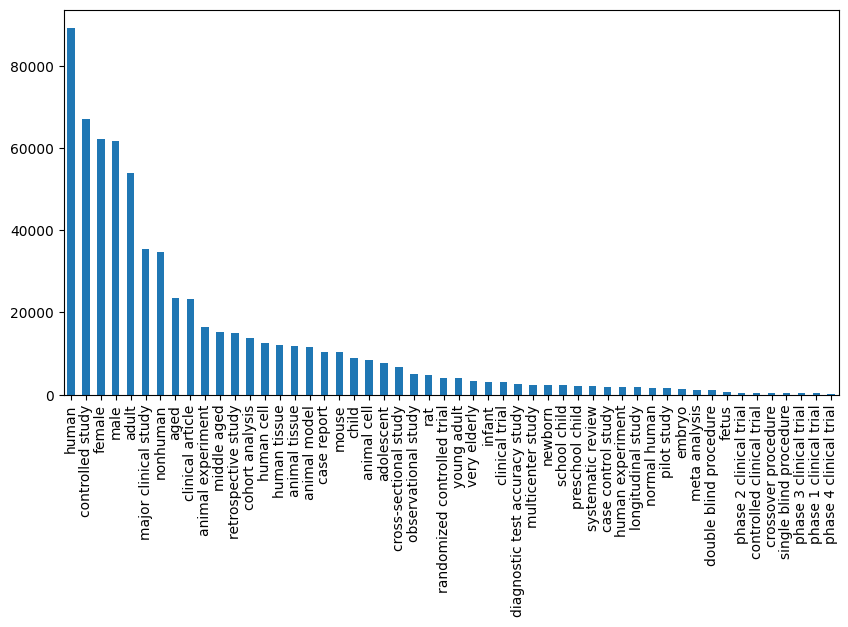

In [55]:
label_occurrences = label_columns.sum().sort_values(ascending=False)
plt.figure(figsize = (10,5))
label_occurrences.plot(kind='bar')

<Axes: >

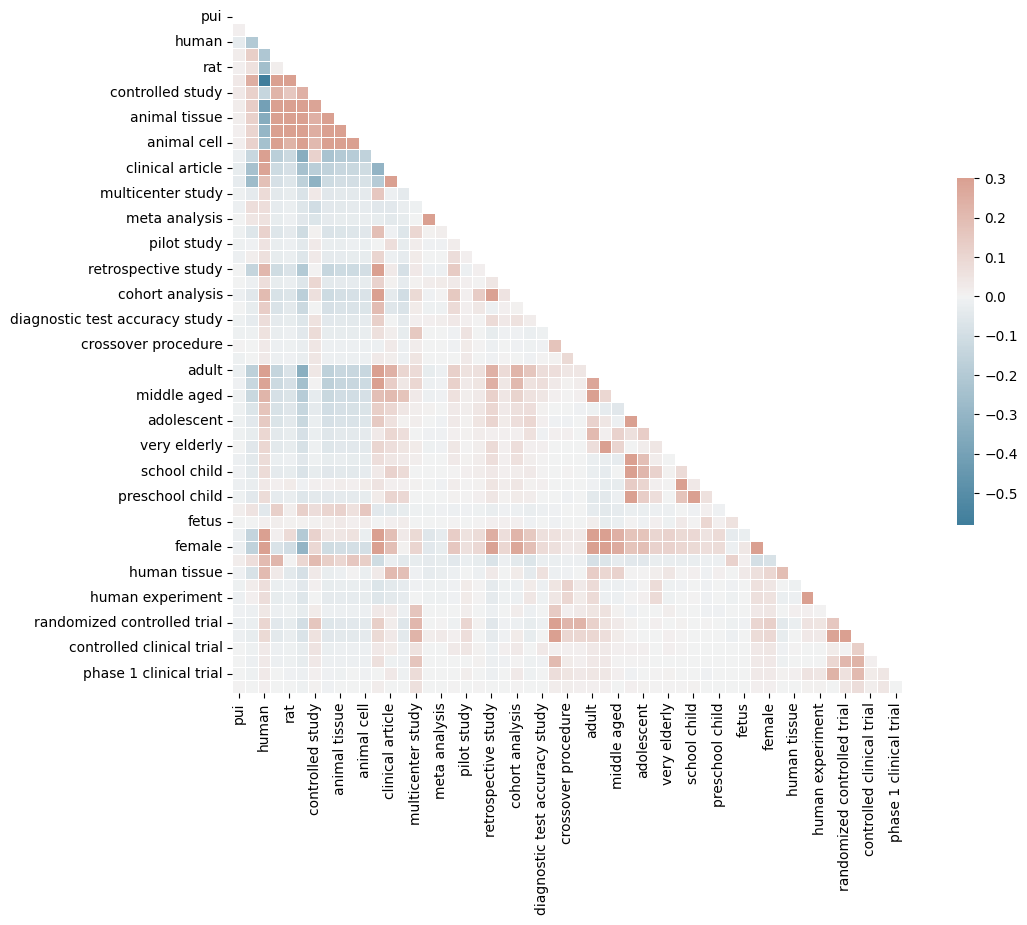

In [56]:
# inspect correlation between labels
corr = data_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [57]:
def collect_pairs(lines, combination_size):
    """Count the co-occurrences of labels."""
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))  # exclude duplicates in same line and sort to ensure one word is always before other
        combos = combinations(unique_tokens, combination_size)
        pair_counter += Counter(combos)
    return pair_counter

In [58]:
# get all the label combinations
label_columns.loc[:, 'label'] = label_columns.apply(lambda row:get_labels(row[label_columns.columns]), axis=1)
all_label_combinations = label_columns['label'].to_list()

In [59]:
# the average number of labels:
print('This is the average number of labels: ', sum([len(l) for l in all_label_combinations])/len(all_label_combinations))
# print('The occurrence of each label: \n', label_columns.sum())

This is the average number of labels:  5.504725259333108


In [60]:
# check the 30 most occurring label combinations
pairs = collect_pairs(all_label_combinations, combination_size=5)
pairs.most_common(30)

KeyboardInterrupt: 

### Check the occurrence and co-occurrence of different author assigned keywords

In [61]:
# get the average number of keywords
keywords_df = \
    data_df['keywords'].\
    dropna().\
    str.replace('[^|\w\s]','', regex=True).\
    str.lower().\
    str.split('|')

keywords_np = keywords_df.to_numpy()

keywords_list_merged = list(itertools.chain.from_iterable(keywords_np))

print(f'The number of unique keywords: {len(np.unique(keywords_list_merged))}')
unique, counts = np.unique(keywords_list_merged, return_counts=True)
print("The most occurring keywords in the dataset: ", sorted(list(zip(unique, counts)), key=lambda x: x[1], reverse=True)[:100])

The number of unique keywords: 181875
The most occurring keywords in the dataset:  [('covid19', 4683), ('sarscov2', 1686), ('inflammation', 1249), ('prognosis', 1146), ('breast cancer', 1008), ('apoptosis', 974), ('obesity', 923), ('children', 914), ('epidemiology', 893), ('depression', 865), ('oxidative stress', 857), ('mortality', 855), ('case report', 779), ('pregnancy', 701), ('cancer', 680), ('quality of life', 678), ('coronavirus', 641), ('risk factors', 599), ('alzheimers disease', 593), ('stroke', 589), ('anxiety', 577), ('diabetes', 565), ('magnetic resonance imaging', 541), ('biomarker', 533), ('diagnosis', 519), ('biomarkers', 511), ('hepatocellular carcinoma', 510), ('pandemic', 496), ('colorectal cancer', 489), ('hypertension', 485), ('machine learning', 481), ('survival', 475), ('surgery', 472), ('treatment', 465), ('mental health', 461), ('metaanalysis', 448), ('immunotherapy', 444), ('heart failure', 440), ('autophagy', 425), ('diabetes mellitus', 416), ('parkinsons dis

### Check the author occurrences

In [62]:
# first create a pivotted table with the article and the authors individually in a second column
author_df = data_df[['pui', 'authors']]
author_df = author_df.explode('authors').reset_index(drop=True)
author_qs = pd.json_normalize(author_df['authors']).reset_index(drop=True)
author_df = pd.concat([author_df, author_qs], axis=1)

In [63]:
# look at the identifiable orcid ids and the occurrences there
print(f'The occurrences of orcid ids in the current dataset: \n', author_df["orcid"].value_counts()[:15])
print(f'The number of authors with only one article under their orcid: ', (author_df["orcid"].value_counts() == 1).sum())
print(f'The occurrences of index names (to see whether name matching would make sense, disclaimer it would not...): \n', author_df["indexed-name"].value_counts()[:20])
single_author_paper = author_df.drop_duplicates(subset=["instance-id", "author-id"])
print(f'The occurrences of authors ids in the current dataset: \n', single_author_paper['author-id'].value_counts()[:15])


The occurrences of orcid ids in the current dataset: 
 0000-0002-6124-7037    24
0000-0002-7189-1707    22
0000-0001-8200-6382    15
0000-0002-1917-5893    14
0000-0002-8995-7583    13
0000-0003-4656-7427    12
0000-0003-3701-8119    11
0000-0002-3652-6085    11
0000-0001-8020-019X    11
0000-0001-7307-2468    10
0000-0001-5411-1492    10
0000-0001-9550-9050    10
0000-0003-1776-9556    10
0000-0002-8502-7952    10
0000-0002-8656-1444    10
Name: orcid, dtype: int64
The number of authors with only one article under their orcid:  76899
The occurrences of index names (to see whether name matching would make sense, disclaimer it would not...): 
 Wang Y.     2451
Zhang Y.    2214
Li Y.       1962
Wang J.     1762
Liu Y.      1740
Wang X.     1716
Li J.       1540
Zhang X.    1521
Li X.       1465
Zhang J.    1462
Chen Y.     1283
Wang L.     1203
Liu J.      1202
Zhang L.    1166
Wang H.     1133
Liu X.      1128
Wang Z.     1071
Zhang H.    1034
Chen J.     1019
Li H.       1001
Name: ind

### Clean text data

In [64]:
from gensim.parsing.preprocessing import remove_stopwords


In [65]:
data_df['abstract'] = data_df['abstract'].fillna(data_df['abstract_2'])
text_df = data_df['abstract'].\
    dropna().\
    str.lower().\
    str.replace('[^|\w\s]','', regex=True).\
    apply(lambda x: remove_stopwords(x))

text_df


0         successful cognitive development childhood adu...
1         benzodiazepines bzds standard treatment anxiet...
2         bipolar disorder bd common mood disorder chara...
4         solidliquid extraction sle solvent different p...
5         background treatment individuals asymptomatic ...
                                ...                        
121364    introduction leiomyosarcoma rare mesenchymal t...
121365    introduction implantbased breast reconstructio...
121366    highway runoff impacts urban natural ecosystem...
121367    objectives remdesivir current recommended anti...
121368    background neuroendocrine tumors net rare tumo...
Name: abstract, Length: 117311, dtype: object

### Check the correlation of the labels with the keywords and the authors

In [232]:
most_common_keywords = sorted(list(zip(unique, counts)), key=lambda x: x[1], reverse=True)
most_common_keywords = [keyword[0] for keyword in most_common_keywords[:100]]
onehot_keyword_df = pd.DataFrame(columns=most_common_keywords, index=data_df.index)

for column in onehot_keyword_df.columns:
    onehot_keyword_df[column] = data_df['keywords'].str.contains(column)

In [93]:
keywords_labels = pd.concat([onehot_keyword_df.reset_index(drop=True), 
                             label_columns.reset_index(drop=True)], axis=1)
keywords_labels.fillna(0, inplace=True)
keywords_labels = keywords_labels.replace({True: 1, False: 0})


<Axes: >

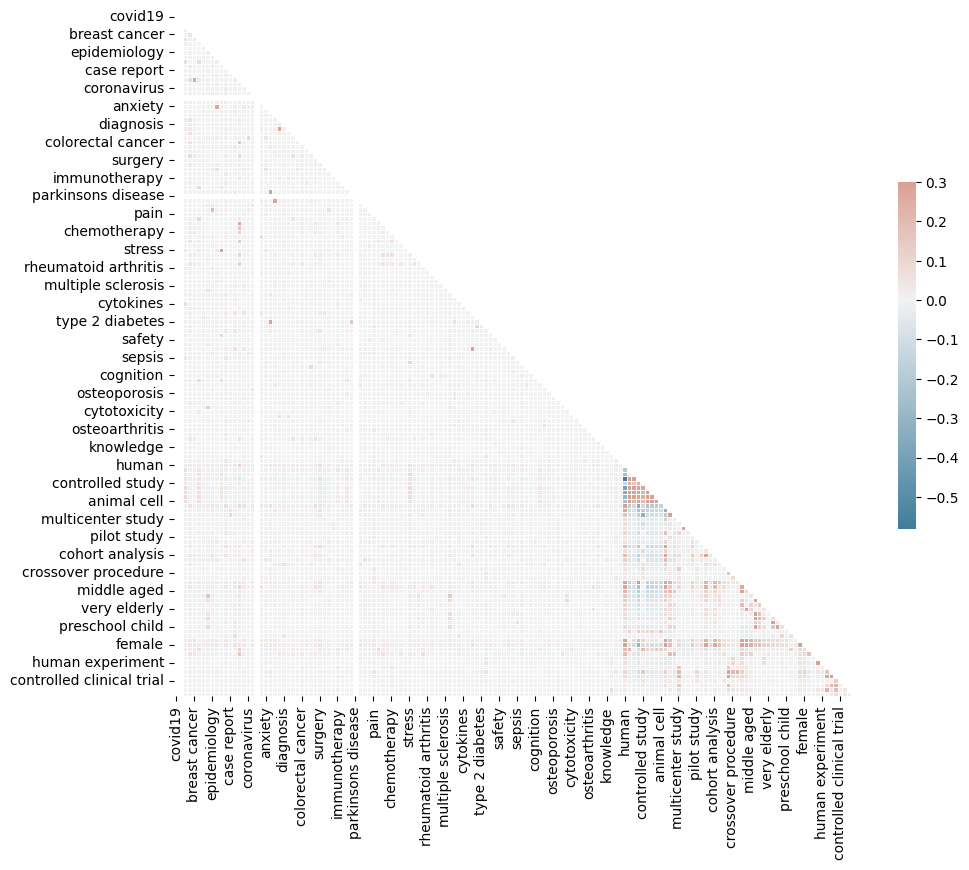

In [94]:
# inspect correlation between labels
keywords_labels_corr = keywords_labels.corr(numeric_only=True)

These are the strongest correlations: 
                  level_0       level_1         0
16       clinical article   case report  0.616459
111      controlled study   case report  0.321993
241  major clinical study   case report  0.193353
248          human tissue   case report  0.188567
265                 human   case report  0.181777
276                 child      children  0.171186
283           middle aged   case report  0.169389
301              nonhuman   case report  0.164841
306          human tissue        cancer  0.162980
333                 child     pediatric  0.148689
399            human cell        cancer  0.124623
423     animal experiment   case report  0.118139
463                 human        cancer  0.112748
477                  aged        cancer  0.110278
506          animal model  inflammation  0.103058
513                 adult   case report  0.102567
515       cohort analysis   case report  0.102457
525            adolescent   adolescents  0.101239
567        

<Axes: >

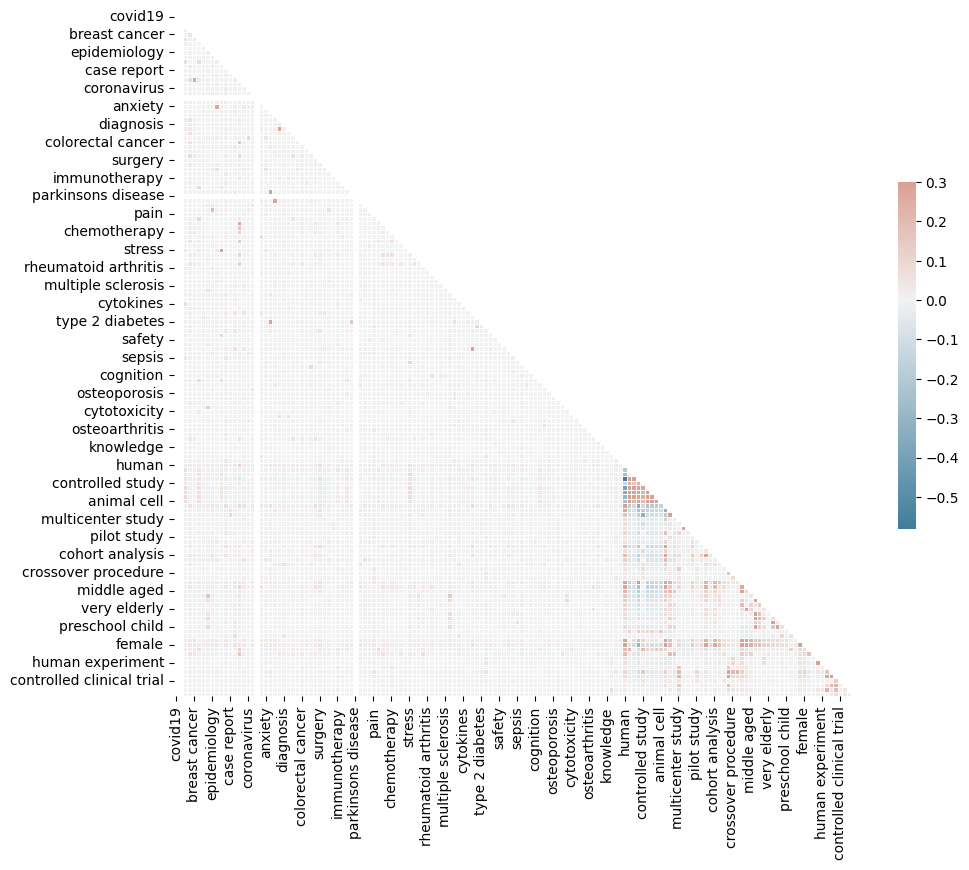

In [107]:
s = keywords_labels_corr.abs().unstack()
so = s.sort_values(kind="quicksort", ascending=False)

correlations = so.loc[(so != 1)].reset_index()
only_keywords_label_combinations = correlations.loc[(correlations['level_0'].isin(label_columns.columns)) & 
                                                    (correlations['level_1'].isin(onehot_keyword_df.columns))] 
print(f'These are the strongest correlations: \n{only_keywords_label_combinations[:25]}')
mask = np.triu(np.ones_like(keywords_labels_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(keywords_labels_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Check the KNN capabilities for assigning multi-labels based on sematic similarity

Get the embeddings ready for the abstracts only.

In [123]:
data_for_embedding = data_df.dropna(subset=['abstract'])
data_df['labels_m'] = data_df['labels_m'].fillna('')
data_df['list_label'] = data_df['labels_m'].str.split(',')

In [ ]:
n = 15000

In [147]:
# tag the documents with all the labels
documents = [TaggedDocument(doc['abstract'], tags=[label]) 
             for i, doc in data_for_embedding[:n].iterrows()
             for label in doc['list_label']]

In [148]:
print(len(documents))


86887


In [173]:
# spin up doc2vec model with the first n documents
model = Doc2Vec(documents, vector_size=256, window=5, min_count=10, workers=4)

In [174]:
train_embedded_docs = np.array([model.infer_vector(doc) for i, doc in data_for_embedding.loc[:n, ['abstract']].iterrows()])
val_embedded_docs = np.array([model.infer_vector(doc) for i, doc in data_for_embedding.loc[n:n+10000, ['abstract']].iterrows()])

Check how easily we can predict labels based on semantic similarity. We shift the classification threshold and see how this effects the different metrics.

In [157]:
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)

thresholds = np.arange(0.1, 0.9, 0.2)
thresholds = [round(threshold, 2) for threshold in thresholds]
scorers = {'recall': recall_score, 'f1_score': f1_score, 'precision': precision_score}

print(thresholds)
scores = {scorer: {key: {} for key in thresholds} for scorer in scorers.keys()}
for label in tqdm(label_columns.columns.difference(['label'])):
    knn.fit(train_embedded_docs, data_for_embedding.loc[:n, label])
    prob_preds = knn.predict_proba(val_embedded_docs)[:,1]
    
    for threshold in thresholds:
        predictions = (prob_preds >= threshold).astype(bool)
#         print(f"Confusion matrix for {label}: \n", confusion_matrix(predictions, val_subset_df[label]))
        
        for scorer_name, scorer in scorers.items():
            score = scorer(predictions, data_for_embedding.loc[n:n+10000, label])
            print(f'{label}-{threshold:.1f}: \t \t The {scorer_name}: {score:.2f}')
            scores[scorer_name][threshold][label] = score

[0.1, 0.3, 0.5, 0.7]


  0%|                                                           | 0/52 [00:00<?, ?it/s]c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▉                                              

adolescent-0.1: 	 	 The recall: 0.07
adolescent-0.1: 	 	 The f1_score: 0.10
adolescent-0.1: 	 	 The precision: 0.25
adolescent-0.3: 	 	 The recall: 0.00
adolescent-0.3: 	 	 The f1_score: 0.00
adolescent-0.3: 	 	 The precision: 0.00
adolescent-0.5: 	 	 The recall: 0.00
adolescent-0.5: 	 	 The f1_score: 0.00
adolescent-0.5: 	 	 The precision: 0.00
adolescent-0.7: 	 	 The recall: 0.00
adolescent-0.7: 	 	 The f1_score: 0.00
adolescent-0.7: 	 	 The precision: 0.00


  4%|█▉                                                 | 2/52 [00:02<01:07,  1.34s/it]

adult-0.1: 	 	 The recall: 0.46
adult-0.1: 	 	 The f1_score: 0.63
adult-0.1: 	 	 The precision: 1.00
adult-0.3: 	 	 The recall: 0.46
adult-0.3: 	 	 The f1_score: 0.61
adult-0.3: 	 	 The precision: 0.93
adult-0.5: 	 	 The recall: 0.45
adult-0.5: 	 	 The f1_score: 0.36
adult-0.5: 	 	 The precision: 0.29
adult-0.7: 	 	 The recall: 0.51
adult-0.7: 	 	 The f1_score: 0.01
adult-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  6%|██▉                                                | 3/52 [00:03<01:02,  1.28s/it]

aged-0.1: 	 	 The recall: 0.20
aged-0.1: 	 	 The f1_score: 0.32
aged-0.1: 	 	 The precision: 0.90
aged-0.3: 	 	 The recall: 0.21
aged-0.3: 	 	 The f1_score: 0.15
aged-0.3: 	 	 The precision: 0.11
aged-0.5: 	 	 The recall: 0.00
aged-0.5: 	 	 The f1_score: 0.00
aged-0.5: 	 	 The precision: 0.00
aged-0.7: 	 	 The recall: 0.00
aged-0.7: 	 	 The f1_score: 0.00
aged-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  8%|███▉                                               | 4/52 [00:05<00:59,  1.25s/it]

animal cell-0.1: 	 	 The recall: 0.07
animal cell-0.1: 	 	 The f1_score: 0.11
animal cell-0.1: 	 	 The precision: 0.26
animal cell-0.3: 	 	 The recall: 0.00
animal cell-0.3: 	 	 The f1_score: 0.00
animal cell-0.3: 	 	 The precision: 0.00
animal cell-0.5: 	 	 The recall: 0.00
animal cell-0.5: 	 	 The f1_score: 0.00
animal cell-0.5: 	 	 The precision: 0.00
animal cell-0.7: 	 	 The recall: 0.00
animal cell-0.7: 	 	 The f1_score: 0.00
animal cell-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|████▉                                              | 5/52 [00:06<00:58,  1.25s/it]

animal experiment-0.1: 	 	 The recall: 0.15
animal experiment-0.1: 	 	 The f1_score: 0.24
animal experiment-0.1: 	 	 The precision: 0.68
animal experiment-0.3: 	 	 The recall: 0.19
animal experiment-0.3: 	 	 The f1_score: 0.03
animal experiment-0.3: 	 	 The precision: 0.02
animal experiment-0.5: 	 	 The recall: 0.00
animal experiment-0.5: 	 	 The f1_score: 0.00
animal experiment-0.5: 	 	 The precision: 0.00
animal experiment-0.7: 	 	 The recall: 0.00
animal experiment-0.7: 	 	 The f1_score: 0.00
animal experiment-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█████▉                                             | 6/52 [00:07<00:58,  1.27s/it]

animal model-0.1: 	 	 The recall: 0.11
animal model-0.1: 	 	 The f1_score: 0.18
animal model-0.1: 	 	 The precision: 0.43
animal model-0.3: 	 	 The recall: 0.08
animal model-0.3: 	 	 The f1_score: 0.00
animal model-0.3: 	 	 The precision: 0.00
animal model-0.5: 	 	 The recall: 0.00
animal model-0.5: 	 	 The f1_score: 0.00
animal model-0.5: 	 	 The precision: 0.00
animal model-0.7: 	 	 The recall: 0.00
animal model-0.7: 	 	 The f1_score: 0.00
animal model-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 13%|██████▊                                            | 7/52 [00:09<01:01,  1.36s/it]

animal tissue-0.1: 	 	 The recall: 0.10
animal tissue-0.1: 	 	 The f1_score: 0.17
animal tissue-0.1: 	 	 The precision: 0.43
animal tissue-0.3: 	 	 The recall: 0.07
animal tissue-0.3: 	 	 The f1_score: 0.00
animal tissue-0.3: 	 	 The precision: 0.00
animal tissue-0.5: 	 	 The recall: 0.00
animal tissue-0.5: 	 	 The f1_score: 0.00
animal tissue-0.5: 	 	 The precision: 0.00
animal tissue-0.7: 	 	 The recall: 0.00
animal tissue-0.7: 	 	 The f1_score: 0.00
animal tissue-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|███████▊                                           | 8/52 [00:10<00:58,  1.32s/it]

case control study-0.1: 	 	 The recall: 0.00
case control study-0.1: 	 	 The f1_score: 0.00
case control study-0.1: 	 	 The precision: 0.00
case control study-0.3: 	 	 The recall: 0.00
case control study-0.3: 	 	 The f1_score: 0.00
case control study-0.3: 	 	 The precision: 0.00
case control study-0.5: 	 	 The recall: 0.00
case control study-0.5: 	 	 The f1_score: 0.00
case control study-0.5: 	 	 The precision: 0.00
case control study-0.7: 	 	 The recall: 0.00
case control study-0.7: 	 	 The f1_score: 0.00
case control study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 17%|████████▊                                          | 9/52 [00:11<00:55,  1.29s/it]

case report-0.1: 	 	 The recall: 0.07
case report-0.1: 	 	 The f1_score: 0.10
case report-0.1: 	 	 The precision: 0.22
case report-0.3: 	 	 The recall: 0.25
case report-0.3: 	 	 The f1_score: 0.00
case report-0.3: 	 	 The precision: 0.00
case report-0.5: 	 	 The recall: 0.00
case report-0.5: 	 	 The f1_score: 0.00
case report-0.5: 	 	 The precision: 0.00
case report-0.7: 	 	 The recall: 0.00
case report-0.7: 	 	 The f1_score: 0.00
case report-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 19%|█████████▌                                        | 10/52 [00:12<00:53,  1.28s/it]

child-0.1: 	 	 The recall: 0.08
child-0.1: 	 	 The f1_score: 0.12
child-0.1: 	 	 The precision: 0.34
child-0.3: 	 	 The recall: 0.00
child-0.3: 	 	 The f1_score: 0.00
child-0.3: 	 	 The precision: 0.00
child-0.5: 	 	 The recall: 0.00
child-0.5: 	 	 The f1_score: 0.00
child-0.5: 	 	 The precision: 0.00
child-0.7: 	 	 The recall: 0.00
child-0.7: 	 	 The f1_score: 0.00
child-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 21%|██████████▌                                       | 11/52 [00:14<00:52,  1.28s/it]

clinical article-0.1: 	 	 The recall: 0.18
clinical article-0.1: 	 	 The f1_score: 0.30
clinical article-0.1: 	 	 The precision: 0.85
clinical article-0.3: 	 	 The recall: 0.17
clinical article-0.3: 	 	 The f1_score: 0.09
clinical article-0.3: 	 	 The precision: 0.06
clinical article-0.5: 	 	 The recall: 0.00
clinical article-0.5: 	 	 The f1_score: 0.00
clinical article-0.5: 	 	 The precision: 0.00
clinical article-0.7: 	 	 The recall: 0.00
clinical article-0.7: 	 	 The f1_score: 0.00
clinical article-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 23%|███████████▌                                      | 12/52 [00:15<00:51,  1.29s/it]

clinical trial-0.1: 	 	 The recall: 0.03
clinical trial-0.1: 	 	 The f1_score: 0.02
clinical trial-0.1: 	 	 The precision: 0.02
clinical trial-0.3: 	 	 The recall: 0.00
clinical trial-0.3: 	 	 The f1_score: 0.00
clinical trial-0.3: 	 	 The precision: 0.00
clinical trial-0.5: 	 	 The recall: 0.00
clinical trial-0.5: 	 	 The f1_score: 0.00
clinical trial-0.5: 	 	 The precision: 0.00
clinical trial-0.7: 	 	 The recall: 0.00
clinical trial-0.7: 	 	 The f1_score: 0.00
clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|████████████▌                                     | 13/52 [00:16<00:49,  1.26s/it]

cohort analysis-0.1: 	 	 The recall: 0.12
cohort analysis-0.1: 	 	 The f1_score: 0.20
cohort analysis-0.1: 	 	 The precision: 0.58
cohort analysis-0.3: 	 	 The recall: 0.10
cohort analysis-0.3: 	 	 The f1_score: 0.01
cohort analysis-0.3: 	 	 The precision: 0.00
cohort analysis-0.5: 	 	 The recall: 0.00
cohort analysis-0.5: 	 	 The f1_score: 0.00
cohort analysis-0.5: 	 	 The precision: 0.00
cohort analysis-0.7: 	 	 The recall: 0.00
cohort analysis-0.7: 	 	 The f1_score: 0.00
cohort analysis-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|█████████████▍                                    | 14/52 [00:17<00:47,  1.24s/it]

controlled clinical trial-0.1: 	 	 The recall: 0.00
controlled clinical trial-0.1: 	 	 The f1_score: 0.00
controlled clinical trial-0.1: 	 	 The precision: 0.00
controlled clinical trial-0.3: 	 	 The recall: 0.00
controlled clinical trial-0.3: 	 	 The f1_score: 0.00
controlled clinical trial-0.3: 	 	 The precision: 0.00
controlled clinical trial-0.5: 	 	 The recall: 0.00
controlled clinical trial-0.5: 	 	 The f1_score: 0.00
controlled clinical trial-0.5: 	 	 The precision: 0.00
controlled clinical trial-0.7: 	 	 The recall: 0.00
controlled clinical trial-0.7: 	 	 The f1_score: 0.00
controlled clinical trial-0.7: 	 	 The precision: 0.00


 29%|██████████████▍                                   | 15/52 [00:19<00:45,  1.23s/it]

controlled study-0.1: 	 	 The recall: 0.58
controlled study-0.1: 	 	 The f1_score: 0.74
controlled study-0.1: 	 	 The precision: 1.00
controlled study-0.3: 	 	 The recall: 0.58
controlled study-0.3: 	 	 The f1_score: 0.74
controlled study-0.3: 	 	 The precision: 1.00
controlled study-0.5: 	 	 The recall: 0.59
controlled study-0.5: 	 	 The f1_score: 0.66
controlled study-0.5: 	 	 The precision: 0.76
controlled study-0.7: 	 	 The recall: 0.60
controlled study-0.7: 	 	 The f1_score: 0.16
controlled study-0.7: 	 	 The precision: 0.09


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 31%|███████████████▍                                  | 16/52 [00:20<00:43,  1.22s/it]

cross-sectional study-0.1: 	 	 The recall: 0.05
cross-sectional study-0.1: 	 	 The f1_score: 0.08
cross-sectional study-0.1: 	 	 The precision: 0.19
cross-sectional study-0.3: 	 	 The recall: 0.00
cross-sectional study-0.3: 	 	 The f1_score: 0.00
cross-sectional study-0.3: 	 	 The precision: 0.00
cross-sectional study-0.5: 	 	 The recall: 0.00
cross-sectional study-0.5: 	 	 The f1_score: 0.00
cross-sectional study-0.5: 	 	 The precision: 0.00
cross-sectional study-0.7: 	 	 The recall: 0.00
cross-sectional study-0.7: 	 	 The f1_score: 0.00
cross-sectional study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 33%|████████████████▎                                 | 17/52 [00:21<00:42,  1.21s/it]

crossover procedure-0.1: 	 	 The recall: 0.00
crossover procedure-0.1: 	 	 The f1_score: 0.00
crossover procedure-0.1: 	 	 The precision: 0.00
crossover procedure-0.3: 	 	 The recall: 0.00
crossover procedure-0.3: 	 	 The f1_score: 0.00
crossover procedure-0.3: 	 	 The precision: 0.00
crossover procedure-0.5: 	 	 The recall: 0.00
crossover procedure-0.5: 	 	 The f1_score: 0.00
crossover procedure-0.5: 	 	 The precision: 0.00
crossover procedure-0.7: 	 	 The recall: 0.00
crossover procedure-0.7: 	 	 The f1_score: 0.00
crossover procedure-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 35%|█████████████████▎                                | 18/52 [00:22<00:40,  1.20s/it]

diagnostic test accuracy study-0.1: 	 	 The recall: 0.02
diagnostic test accuracy study-0.1: 	 	 The f1_score: 0.02
diagnostic test accuracy study-0.1: 	 	 The precision: 0.03
diagnostic test accuracy study-0.3: 	 	 The recall: 0.00
diagnostic test accuracy study-0.3: 	 	 The f1_score: 0.00
diagnostic test accuracy study-0.3: 	 	 The precision: 0.00
diagnostic test accuracy study-0.5: 	 	 The recall: 0.00
diagnostic test accuracy study-0.5: 	 	 The f1_score: 0.00
diagnostic test accuracy study-0.5: 	 	 The precision: 0.00
diagnostic test accuracy study-0.7: 	 	 The recall: 0.00
diagnostic test accuracy study-0.7: 	 	 The f1_score: 0.00
diagnostic test accuracy study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 37%|██████████████████▎                               | 19/52 [00:23<00:40,  1.22s/it]

double blind procedure-0.1: 	 	 The recall: 0.00
double blind procedure-0.1: 	 	 The f1_score: 0.00
double blind procedure-0.1: 	 	 The precision: 0.00
double blind procedure-0.3: 	 	 The recall: 0.00
double blind procedure-0.3: 	 	 The f1_score: 0.00
double blind procedure-0.3: 	 	 The precision: 0.00
double blind procedure-0.5: 	 	 The recall: 0.00
double blind procedure-0.5: 	 	 The f1_score: 0.00
double blind procedure-0.5: 	 	 The precision: 0.00
double blind procedure-0.7: 	 	 The recall: 0.00
double blind procedure-0.7: 	 	 The f1_score: 0.00
double blind procedure-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 38%|███████████████████▏                              | 20/52 [00:25<00:38,  1.21s/it]

embryo-0.1: 	 	 The recall: 0.05
embryo-0.1: 	 	 The f1_score: 0.02
embryo-0.1: 	 	 The precision: 0.01
embryo-0.3: 	 	 The recall: 0.00
embryo-0.3: 	 	 The f1_score: 0.00
embryo-0.3: 	 	 The precision: 0.00
embryo-0.5: 	 	 The recall: 0.00
embryo-0.5: 	 	 The f1_score: 0.00
embryo-0.5: 	 	 The precision: 0.00
embryo-0.7: 	 	 The recall: 0.00
embryo-0.7: 	 	 The f1_score: 0.00
embryo-0.7: 	 	 The precision: 0.00


 40%|████████████████████▏                             | 21/52 [00:26<00:37,  1.21s/it]

female-0.1: 	 	 The recall: 0.54
female-0.1: 	 	 The f1_score: 0.70
female-0.1: 	 	 The precision: 1.00
female-0.3: 	 	 The recall: 0.54
female-0.3: 	 	 The f1_score: 0.69
female-0.3: 	 	 The precision: 0.99
female-0.5: 	 	 The recall: 0.53
female-0.5: 	 	 The f1_score: 0.57
female-0.5: 	 	 The precision: 0.60
female-0.7: 	 	 The recall: 0.52
female-0.7: 	 	 The f1_score: 0.07
female-0.7: 	 	 The precision: 0.04


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 42%|█████████████████████▏                            | 22/52 [00:27<00:36,  1.21s/it]

fetus-0.1: 	 	 The recall: 0.00
fetus-0.1: 	 	 The f1_score: 0.00
fetus-0.1: 	 	 The precision: 0.00
fetus-0.3: 	 	 The recall: 0.00
fetus-0.3: 	 	 The f1_score: 0.00
fetus-0.3: 	 	 The precision: 0.00
fetus-0.5: 	 	 The recall: 0.00
fetus-0.5: 	 	 The f1_score: 0.00
fetus-0.5: 	 	 The precision: 0.00
fetus-0.7: 	 	 The recall: 0.00
fetus-0.7: 	 	 The f1_score: 0.00
fetus-0.7: 	 	 The precision: 0.00


 44%|██████████████████████                            | 23/52 [00:28<00:34,  1.20s/it]

human-0.1: 	 	 The recall: 0.72
human-0.1: 	 	 The f1_score: 0.84
human-0.1: 	 	 The precision: 1.00
human-0.3: 	 	 The recall: 0.72
human-0.3: 	 	 The f1_score: 0.84
human-0.3: 	 	 The precision: 1.00
human-0.5: 	 	 The recall: 0.72
human-0.5: 	 	 The f1_score: 0.84
human-0.5: 	 	 The precision: 0.99
human-0.7: 	 	 The recall: 0.73
human-0.7: 	 	 The f1_score: 0.69
human-0.7: 	 	 The precision: 0.66


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 46%|███████████████████████                           | 24/52 [00:29<00:33,  1.20s/it]

human cell-0.1: 	 	 The recall: 0.11
human cell-0.1: 	 	 The f1_score: 0.19
human cell-0.1: 	 	 The precision: 0.51
human cell-0.3: 	 	 The recall: 0.21
human cell-0.3: 	 	 The f1_score: 0.01
human cell-0.3: 	 	 The precision: 0.01
human cell-0.5: 	 	 The recall: 0.00
human cell-0.5: 	 	 The f1_score: 0.00
human cell-0.5: 	 	 The precision: 0.00
human cell-0.7: 	 	 The recall: 0.00
human cell-0.7: 	 	 The f1_score: 0.00
human cell-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 48%|████████████████████████                          | 25/52 [00:31<00:32,  1.20s/it]

human experiment-0.1: 	 	 The recall: 0.01
human experiment-0.1: 	 	 The f1_score: 0.01
human experiment-0.1: 	 	 The precision: 0.01
human experiment-0.3: 	 	 The recall: 0.00
human experiment-0.3: 	 	 The f1_score: 0.00
human experiment-0.3: 	 	 The precision: 0.00
human experiment-0.5: 	 	 The recall: 0.00
human experiment-0.5: 	 	 The f1_score: 0.00
human experiment-0.5: 	 	 The precision: 0.00
human experiment-0.7: 	 	 The recall: 0.00
human experiment-0.7: 	 	 The f1_score: 0.00
human experiment-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 50%|█████████████████████████                         | 26/52 [00:32<00:31,  1.20s/it]

human tissue-0.1: 	 	 The recall: 0.09
human tissue-0.1: 	 	 The f1_score: 0.15
human tissue-0.1: 	 	 The precision: 0.38
human tissue-0.3: 	 	 The recall: 0.00
human tissue-0.3: 	 	 The f1_score: 0.00
human tissue-0.3: 	 	 The precision: 0.00
human tissue-0.5: 	 	 The recall: 0.00
human tissue-0.5: 	 	 The f1_score: 0.00
human tissue-0.5: 	 	 The precision: 0.00
human tissue-0.7: 	 	 The recall: 0.00
human tissue-0.7: 	 	 The f1_score: 0.00
human tissue-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 52%|█████████████████████████▉                        | 27/52 [00:33<00:30,  1.20s/it]

infant-0.1: 	 	 The recall: 0.02
infant-0.1: 	 	 The f1_score: 0.03
infant-0.1: 	 	 The precision: 0.03
infant-0.3: 	 	 The recall: 0.00
infant-0.3: 	 	 The f1_score: 0.00
infant-0.3: 	 	 The precision: 0.00
infant-0.5: 	 	 The recall: 0.00
infant-0.5: 	 	 The f1_score: 0.00
infant-0.5: 	 	 The precision: 0.00
infant-0.7: 	 	 The recall: 0.00
infant-0.7: 	 	 The f1_score: 0.00
infant-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 54%|██████████████████████████▉                       | 28/52 [00:34<00:28,  1.20s/it]

longitudinal study-0.1: 	 	 The recall: 0.01
longitudinal study-0.1: 	 	 The f1_score: 0.01
longitudinal study-0.1: 	 	 The precision: 0.01
longitudinal study-0.3: 	 	 The recall: 0.00
longitudinal study-0.3: 	 	 The f1_score: 0.00
longitudinal study-0.3: 	 	 The precision: 0.00
longitudinal study-0.5: 	 	 The recall: 0.00
longitudinal study-0.5: 	 	 The f1_score: 0.00
longitudinal study-0.5: 	 	 The precision: 0.00
longitudinal study-0.7: 	 	 The recall: 0.00
longitudinal study-0.7: 	 	 The f1_score: 0.00
longitudinal study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|███████████████████████████▉                      | 29/52 [00:35<00:27,  1.20s/it]

major clinical study-0.1: 	 	 The recall: 0.30
major clinical study-0.1: 	 	 The f1_score: 0.47
major clinical study-0.1: 	 	 The precision: 0.99
major clinical study-0.3: 	 	 The recall: 0.30
major clinical study-0.3: 	 	 The f1_score: 0.37
major clinical study-0.3: 	 	 The precision: 0.49
major clinical study-0.5: 	 	 The recall: 0.31
major clinical study-0.5: 	 	 The f1_score: 0.03
major clinical study-0.5: 	 	 The precision: 0.02
major clinical study-0.7: 	 	 The recall: 0.00
major clinical study-0.7: 	 	 The f1_score: 0.00
major clinical study-0.7: 	 	 The precision: 0.00


 58%|████████████████████████████▊                     | 30/52 [00:37<00:26,  1.20s/it]

male-0.1: 	 	 The recall: 0.53
male-0.1: 	 	 The f1_score: 0.69
male-0.1: 	 	 The precision: 1.00
male-0.3: 	 	 The recall: 0.53
male-0.3: 	 	 The f1_score: 0.69
male-0.3: 	 	 The precision: 0.99
male-0.5: 	 	 The recall: 0.53
male-0.5: 	 	 The f1_score: 0.56
male-0.5: 	 	 The precision: 0.59
male-0.7: 	 	 The recall: 0.56
male-0.7: 	 	 The f1_score: 0.07
male-0.7: 	 	 The precision: 0.04


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|█████████████████████████████▊                    | 31/52 [00:38<00:25,  1.20s/it]

meta analysis-0.1: 	 	 The recall: 0.00
meta analysis-0.1: 	 	 The f1_score: 0.00
meta analysis-0.1: 	 	 The precision: 0.00
meta analysis-0.3: 	 	 The recall: 0.00
meta analysis-0.3: 	 	 The f1_score: 0.00
meta analysis-0.3: 	 	 The precision: 0.00
meta analysis-0.5: 	 	 The recall: 0.00
meta analysis-0.5: 	 	 The f1_score: 0.00
meta analysis-0.5: 	 	 The precision: 0.00
meta analysis-0.7: 	 	 The recall: 0.00
meta analysis-0.7: 	 	 The f1_score: 0.00
meta analysis-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 62%|██████████████████████████████▊                   | 32/52 [00:39<00:24,  1.20s/it]

middle aged-0.1: 	 	 The recall: 0.12
middle aged-0.1: 	 	 The f1_score: 0.19
middle aged-0.1: 	 	 The precision: 0.57
middle aged-0.3: 	 	 The recall: 0.13
middle aged-0.3: 	 	 The f1_score: 0.01
middle aged-0.3: 	 	 The precision: 0.01
middle aged-0.5: 	 	 The recall: 0.00
middle aged-0.5: 	 	 The f1_score: 0.00
middle aged-0.5: 	 	 The precision: 0.00
middle aged-0.7: 	 	 The recall: 0.00
middle aged-0.7: 	 	 The f1_score: 0.00
middle aged-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 63%|███████████████████████████████▋                  | 33/52 [00:40<00:22,  1.20s/it]

mouse-0.1: 	 	 The recall: 0.10
mouse-0.1: 	 	 The f1_score: 0.15
mouse-0.1: 	 	 The precision: 0.36
mouse-0.3: 	 	 The recall: 0.00
mouse-0.3: 	 	 The f1_score: 0.00
mouse-0.3: 	 	 The precision: 0.00
mouse-0.5: 	 	 The recall: 0.00
mouse-0.5: 	 	 The f1_score: 0.00
mouse-0.5: 	 	 The precision: 0.00
mouse-0.7: 	 	 The recall: 0.00
mouse-0.7: 	 	 The f1_score: 0.00
mouse-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 65%|████████████████████████████████▋                 | 34/52 [00:41<00:21,  1.20s/it]

multicenter study-0.1: 	 	 The recall: 0.01
multicenter study-0.1: 	 	 The f1_score: 0.01
multicenter study-0.1: 	 	 The precision: 0.00
multicenter study-0.3: 	 	 The recall: 0.00
multicenter study-0.3: 	 	 The f1_score: 0.00
multicenter study-0.3: 	 	 The precision: 0.00
multicenter study-0.5: 	 	 The recall: 0.00
multicenter study-0.5: 	 	 The f1_score: 0.00
multicenter study-0.5: 	 	 The precision: 0.00
multicenter study-0.7: 	 	 The recall: 0.00
multicenter study-0.7: 	 	 The f1_score: 0.00
multicenter study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 67%|█████████████████████████████████▋                | 35/52 [00:43<00:20,  1.20s/it]

newborn-0.1: 	 	 The recall: 0.01
newborn-0.1: 	 	 The f1_score: 0.01
newborn-0.1: 	 	 The precision: 0.00
newborn-0.3: 	 	 The recall: 0.00
newborn-0.3: 	 	 The f1_score: 0.00
newborn-0.3: 	 	 The precision: 0.00
newborn-0.5: 	 	 The recall: 0.00
newborn-0.5: 	 	 The f1_score: 0.00
newborn-0.5: 	 	 The precision: 0.00
newborn-0.7: 	 	 The recall: 0.00
newborn-0.7: 	 	 The f1_score: 0.00
newborn-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 69%|██████████████████████████████████▌               | 36/52 [00:44<00:19,  1.20s/it]

nonhuman-0.1: 	 	 The recall: 0.29
nonhuman-0.1: 	 	 The f1_score: 0.45
nonhuman-0.1: 	 	 The precision: 0.99
nonhuman-0.3: 	 	 The recall: 0.30
nonhuman-0.3: 	 	 The f1_score: 0.37
nonhuman-0.3: 	 	 The precision: 0.48
nonhuman-0.5: 	 	 The recall: 0.31
nonhuman-0.5: 	 	 The f1_score: 0.03
nonhuman-0.5: 	 	 The precision: 0.01
nonhuman-0.7: 	 	 The recall: 0.00
nonhuman-0.7: 	 	 The f1_score: 0.00
nonhuman-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 71%|███████████████████████████████████▌              | 37/52 [00:45<00:18,  1.21s/it]

normal human-0.1: 	 	 The recall: 0.02
normal human-0.1: 	 	 The f1_score: 0.01
normal human-0.1: 	 	 The precision: 0.01
normal human-0.3: 	 	 The recall: 0.00
normal human-0.3: 	 	 The f1_score: 0.00
normal human-0.3: 	 	 The precision: 0.00
normal human-0.5: 	 	 The recall: 0.00
normal human-0.5: 	 	 The f1_score: 0.00
normal human-0.5: 	 	 The precision: 0.00
normal human-0.7: 	 	 The recall: 0.00
normal human-0.7: 	 	 The f1_score: 0.00
normal human-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 73%|████████████████████████████████████▌             | 38/52 [00:46<00:16,  1.21s/it]

observational study-0.1: 	 	 The recall: 0.04
observational study-0.1: 	 	 The f1_score: 0.05
observational study-0.1: 	 	 The precision: 0.06
observational study-0.3: 	 	 The recall: 0.00
observational study-0.3: 	 	 The f1_score: 0.00
observational study-0.3: 	 	 The precision: 0.00
observational study-0.5: 	 	 The recall: 0.00
observational study-0.5: 	 	 The f1_score: 0.00
observational study-0.5: 	 	 The precision: 0.00
observational study-0.7: 	 	 The recall: 0.00
observational study-0.7: 	 	 The f1_score: 0.00
observational study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 75%|█████████████████████████████████████▌            | 39/52 [00:47<00:15,  1.20s/it]

phase 1 clinical trial-0.1: 	 	 The recall: 0.00
phase 1 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.1: 	 	 The precision: 0.00
phase 1 clinical trial-0.3: 	 	 The recall: 0.00
phase 1 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.3: 	 	 The precision: 0.00
phase 1 clinical trial-0.5: 	 	 The recall: 0.00
phase 1 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.5: 	 	 The precision: 0.00
phase 1 clinical trial-0.7: 	 	 The recall: 0.00
phase 1 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and bein

phase 2 clinical trial-0.1: 	 	 The recall: 0.00
phase 2 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.1: 	 	 The precision: 0.00
phase 2 clinical trial-0.3: 	 	 The recall: 0.00
phase 2 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.3: 	 	 The precision: 0.00
phase 2 clinical trial-0.5: 	 	 The recall: 0.00
phase 2 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.5: 	 	 The precision: 0.00
phase 2 clinical trial-0.7: 	 	 The recall: 0.00
phase 2 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 79%|███████████████████████████████████████▍          | 41/52 [00:50<00:13,  1.20s/it]

phase 3 clinical trial-0.1: 	 	 The recall: 0.00
phase 3 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.1: 	 	 The precision: 0.00
phase 3 clinical trial-0.3: 	 	 The recall: 0.00
phase 3 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.3: 	 	 The precision: 0.00
phase 3 clinical trial-0.5: 	 	 The recall: 0.00
phase 3 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.5: 	 	 The precision: 0.00
phase 3 clinical trial-0.7: 	 	 The recall: 0.00
phase 3 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and bein

phase 4 clinical trial-0.1: 	 	 The recall: 0.00
phase 4 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.1: 	 	 The precision: 0.00
phase 4 clinical trial-0.3: 	 	 The recall: 0.00
phase 4 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.3: 	 	 The precision: 0.00
phase 4 clinical trial-0.5: 	 	 The recall: 0.00
phase 4 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.5: 	 	 The precision: 0.00
phase 4 clinical trial-0.7: 	 	 The recall: 0.00
phase 4 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 83%|█████████████████████████████████████████▎        | 43/52 [00:52<00:10,  1.20s/it]

pilot study-0.1: 	 	 The recall: 0.00
pilot study-0.1: 	 	 The f1_score: 0.00
pilot study-0.1: 	 	 The precision: 0.00
pilot study-0.3: 	 	 The recall: 0.00
pilot study-0.3: 	 	 The f1_score: 0.00
pilot study-0.3: 	 	 The precision: 0.00
pilot study-0.5: 	 	 The recall: 0.00
pilot study-0.5: 	 	 The f1_score: 0.00
pilot study-0.5: 	 	 The precision: 0.00
pilot study-0.7: 	 	 The recall: 0.00
pilot study-0.7: 	 	 The f1_score: 0.00
pilot study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 85%|██████████████████████████████████████████▎       | 44/52 [00:53<00:09,  1.20s/it]

preschool child-0.1: 	 	 The recall: 0.02
preschool child-0.1: 	 	 The f1_score: 0.02
preschool child-0.1: 	 	 The precision: 0.01
preschool child-0.3: 	 	 The recall: 0.00
preschool child-0.3: 	 	 The f1_score: 0.00
preschool child-0.3: 	 	 The precision: 0.00
preschool child-0.5: 	 	 The recall: 0.00
preschool child-0.5: 	 	 The f1_score: 0.00
preschool child-0.5: 	 	 The precision: 0.00
preschool child-0.7: 	 	 The recall: 0.00
preschool child-0.7: 	 	 The f1_score: 0.00
preschool child-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 87%|███████████████████████████████████████████▎      | 45/52 [00:55<00:08,  1.20s/it]

randomized controlled trial-0.1: 	 	 The recall: 0.04
randomized controlled trial-0.1: 	 	 The f1_score: 0.05
randomized controlled trial-0.1: 	 	 The precision: 0.05
randomized controlled trial-0.3: 	 	 The recall: 0.00
randomized controlled trial-0.3: 	 	 The f1_score: 0.00
randomized controlled trial-0.3: 	 	 The precision: 0.00
randomized controlled trial-0.5: 	 	 The recall: 0.00
randomized controlled trial-0.5: 	 	 The f1_score: 0.00
randomized controlled trial-0.5: 	 	 The precision: 0.00
randomized controlled trial-0.7: 	 	 The recall: 0.00
randomized controlled trial-0.7: 	 	 The f1_score: 0.00
randomized controlled trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 88%|████████████████████████████████████████████▏     | 46/52 [00:56<00:07,  1.20s/it]

rat-0.1: 	 	 The recall: 0.04
rat-0.1: 	 	 The f1_score: 0.06
rat-0.1: 	 	 The precision: 0.09
rat-0.3: 	 	 The recall: 0.00
rat-0.3: 	 	 The f1_score: 0.00
rat-0.3: 	 	 The precision: 0.00
rat-0.5: 	 	 The recall: 0.00
rat-0.5: 	 	 The f1_score: 0.00
rat-0.5: 	 	 The precision: 0.00
rat-0.7: 	 	 The recall: 0.00
rat-0.7: 	 	 The f1_score: 0.00
rat-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|█████████████████████████████████████████████▏    | 47/52 [00:57<00:06,  1.20s/it]

retrospective study-0.1: 	 	 The recall: 0.13
retrospective study-0.1: 	 	 The f1_score: 0.22
retrospective study-0.1: 	 	 The precision: 0.67
retrospective study-0.3: 	 	 The recall: 0.08
retrospective study-0.3: 	 	 The f1_score: 0.01
retrospective study-0.3: 	 	 The precision: 0.01
retrospective study-0.5: 	 	 The recall: 0.00
retrospective study-0.5: 	 	 The f1_score: 0.00
retrospective study-0.5: 	 	 The precision: 0.00
retrospective study-0.7: 	 	 The recall: 0.00
retrospective study-0.7: 	 	 The f1_score: 0.00
retrospective study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 92%|██████████████████████████████████████████████▏   | 48/52 [00:58<00:04,  1.20s/it]

school child-0.1: 	 	 The recall: 0.02
school child-0.1: 	 	 The f1_score: 0.02
school child-0.1: 	 	 The precision: 0.03
school child-0.3: 	 	 The recall: 0.00
school child-0.3: 	 	 The f1_score: 0.00
school child-0.3: 	 	 The precision: 0.00
school child-0.5: 	 	 The recall: 0.00
school child-0.5: 	 	 The f1_score: 0.00
school child-0.5: 	 	 The precision: 0.00
school child-0.7: 	 	 The recall: 0.00
school child-0.7: 	 	 The f1_score: 0.00
school child-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and bein

single blind procedure-0.1: 	 	 The recall: 0.00
single blind procedure-0.1: 	 	 The f1_score: 0.00
single blind procedure-0.1: 	 	 The precision: 0.00
single blind procedure-0.3: 	 	 The recall: 0.00
single blind procedure-0.3: 	 	 The f1_score: 0.00
single blind procedure-0.3: 	 	 The precision: 0.00
single blind procedure-0.5: 	 	 The recall: 0.00
single blind procedure-0.5: 	 	 The f1_score: 0.00
single blind procedure-0.5: 	 	 The precision: 0.00
single blind procedure-0.7: 	 	 The recall: 0.00
single blind procedure-0.7: 	 	 The f1_score: 0.00
single blind procedure-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 96%|████████████████████████████████████████████████  | 50/52 [01:01<00:02,  1.20s/it]

systematic review-0.1: 	 	 The recall: 0.03
systematic review-0.1: 	 	 The f1_score: 0.02
systematic review-0.1: 	 	 The precision: 0.01
systematic review-0.3: 	 	 The recall: 0.00
systematic review-0.3: 	 	 The f1_score: 0.00
systematic review-0.3: 	 	 The precision: 0.00
systematic review-0.5: 	 	 The recall: 0.00
systematic review-0.5: 	 	 The f1_score: 0.00
systematic review-0.5: 	 	 The precision: 0.00
systematic review-0.7: 	 	 The recall: 0.00
systematic review-0.7: 	 	 The f1_score: 0.00
systematic review-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 98%|█████████████████████████████████████████████████ | 51/52 [01:02<00:01,  1.20s/it]

very elderly-0.1: 	 	 The recall: 0.02
very elderly-0.1: 	 	 The f1_score: 0.02
very elderly-0.1: 	 	 The precision: 0.02
very elderly-0.3: 	 	 The recall: 0.00
very elderly-0.3: 	 	 The f1_score: 0.00
very elderly-0.3: 	 	 The precision: 0.00
very elderly-0.5: 	 	 The recall: 0.00
very elderly-0.5: 	 	 The f1_score: 0.00
very elderly-0.5: 	 	 The precision: 0.00
very elderly-0.7: 	 	 The recall: 0.00
very elderly-0.7: 	 	 The f1_score: 0.00
very elderly-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████████████████████████████████████████████| 52/52 [01:03<00:00,  1.22s/it]

young adult-0.1: 	 	 The recall: 0.03
young adult-0.1: 	 	 The f1_score: 0.04
young adult-0.1: 	 	 The precision: 0.05
young adult-0.3: 	 	 The recall: 0.00
young adult-0.3: 	 	 The f1_score: 0.00
young adult-0.3: 	 	 The precision: 0.00
young adult-0.5: 	 	 The recall: 0.00
young adult-0.5: 	 	 The f1_score: 0.00
young adult-0.5: 	 	 The precision: 0.00
young adult-0.7: 	 	 The recall: 0.00
young adult-0.7: 	 	 The f1_score: 0.00
young adult-0.7: 	 	 The precision: 0.00


D:\Users\bergr2\AppData\Local\Temp\ipykernel_11748\1617331084.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Users\bergr2\AppData\Local\Temp\ipykernel_11748\1617331084.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Users\bergr2\AppData\Local\Temp\ipykernel_11748\1617331084.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


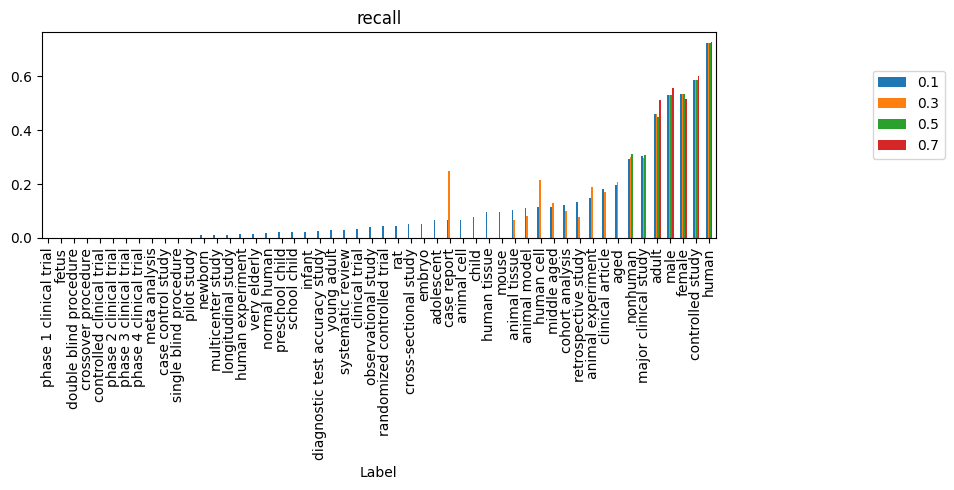

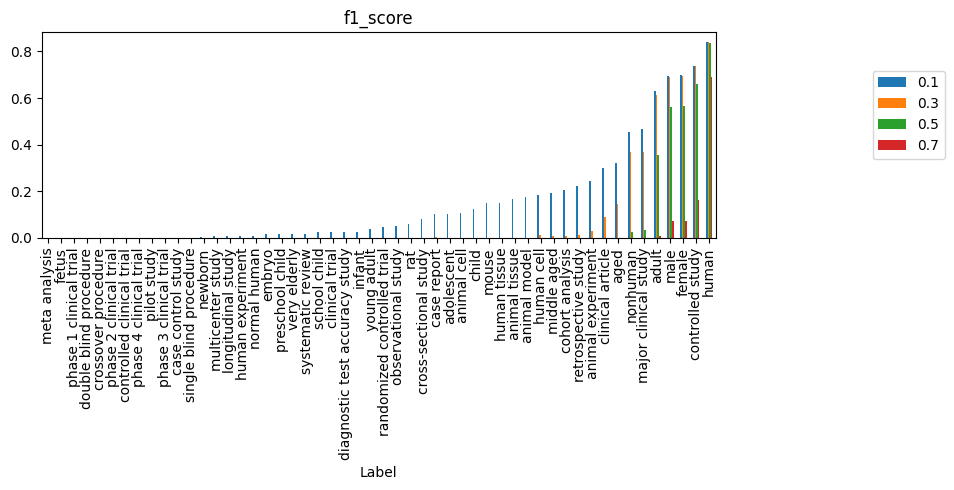

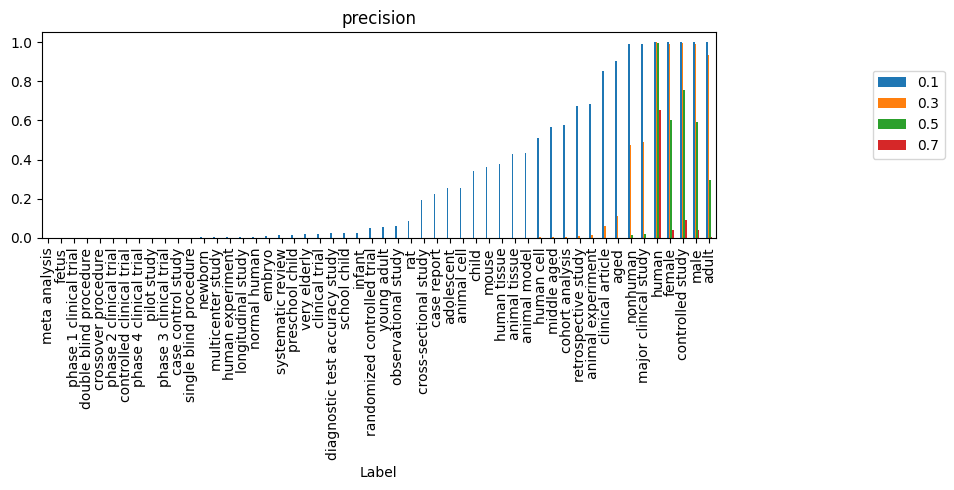

In [172]:
# check the effect of the prediction threshold on the different scores
for scorer_name, scorer in scorers.items():
    df = pd.DataFrame(list(scores[scorer_name].values()), index=list(scores[scorer_name].keys())).transpose()
#     print(df.columns)
#     print(df.sort_values(by=0.1))
    fig, ax= plt.subplots(1,1, figsize=(10,5))
    ax.set_title(f'{scorer_name}')
    df.sort_values(by=0.1).plot.bar(ax=ax)
    ax.set_xlabel('Label')
    plt.legend(bbox_to_anchor = (1.35, 0.6), loc='center right')
    fig.tight_layout()
    fig.show()

### Compose different networks

In [206]:
import itertools
import networkx as nx

In [190]:
author_grouped_df = author_df[['pui', 'author-id']].groupby('author-id')
author_grouped_sizes_df = author_grouped_df.size()
author_grouped_get_combinations_df = author_grouped_df.apply(lambda x: list(itertools.combinations(x['pui'].tolist(), 2)))

In [204]:
author_grouped_get_combinations_not_empty = author_grouped_get_combinations_df[author_grouped_get_combinations_df.map(lambda d: len(d)) > 0]

all_author_links = author_grouped_get_combinations_not_empty.to_frame().explode(0)
all_author_links[['from', 'to']] = pd.DataFrame(all_author_links[0].tolist(), index=all_author_links.index)
all_author_links.drop(0, inplace=True, axis=1)

In [205]:
all_author_links

,from,to
author-id,,
00000230d383398b67a78ead04d3ebeb,2010789928,2010789928
00000230d383398b67a78ead04d3ebeb,2010789928,2010263956
00000230d383398b67a78ead04d3ebeb,2010789928,2010263956
0000560cb202098232ad006166ce3f83,2010922163,2010922163
000147c89944d3105a91e4b12f3dc9c3,2007048258,2007048258
...,...,...
ffff2e17f92973ca0e33245e85d57304,2007656704,2007656704
ffff2e17f92973ca0e33245e85d57304,2007656704,2007656704
ffff2e17f92973ca0e33245e85d57304,2007656704,2007656704


In [208]:
author_graph = nx.from_pandas_edgelist(all_author_links, source='from', target='to')

Average degree: 4.548719450137326


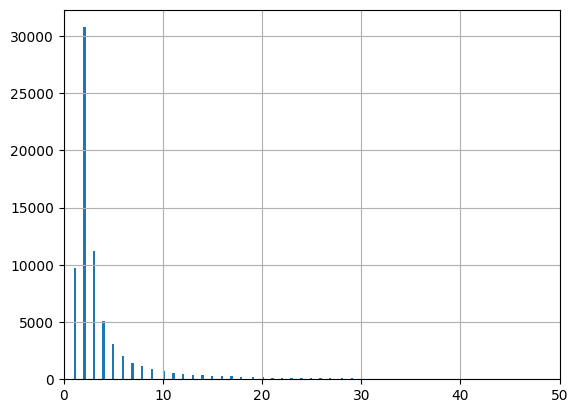

In [231]:
all_degrees = [v for _, v in nx.degree(author_graph)]
print(f'Average degree: {sum(all_degrees)/len(all_degrees)}')
plt.figure()
plt.xlim(0,50)
plt.hist(all_degrees, bins=1000)
plt.grid()